# LQR and LQE Template

Import modules and configure the notebook.

In [1]:
# Standard modules
import time
import numpy as np
import numpy.linalg as la
import sympy as sym
import scipy as sci
import scipy.linalg as sla
import scipy.signal as sig
import matplotlib.pyplot as plt
from collections import Counter
import json
import pandas as pd

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')

# My own script (an interface to the simulator)
import ae353_spacecraft

/var/folders/84/3j3h65z55vs1f4cfjg8vd24r0000gn/T/ipykernel_6665/3665895471.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')
pybullet build time: Jan 28 2022 20:18:15


Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here is one optional argument you may want to use:

* `display` (`True` or `False`) is whether or not to show the simulation window 
-   (Running with `display = False` makes simulations run faster);
-   Recommend to run with `display = False` for data collection, run with `display = True` only if visualization is needed

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [2]:
simulator = ae353_spacecraft.Simulator(
    display=False,
)

Here is how to find the location of each star:

In [3]:
for (i, star) in enumerate(simulator.stars):
    print(f'star {i} : alpha = {star["alpha"]:5.2f} : delta = {star["delta"]:5.2f}')

star 0 : alpha = -0.10 : delta = -0.15
star 1 : alpha =  0.00 : delta = -0.15
star 2 : alpha =  0.10 : delta = -0.15
star 3 : alpha =  0.00 : delta =  0.00
star 4 : alpha = -0.10 : delta =  0.15
star 5 : alpha =  0.00 : delta =  0.15
star 6 : alpha =  0.10 : delta =  0.15


Defining physical constants of the spacecraft for the dynamic model

In [4]:
# Mass and MOI of base
mb = 6.
Jxb = 10.
Jyb = 10.
Jzb = 16.

# Mass and MOI of each wheel
mw = 1.
Jxw = 0.075
Jyw = 0.075
Jzw = 0.125
lw = 1.1

Defining variables associated with the dynamic model and deriving the equations for the dynamic model

In [5]:
# Define yaw, pitch, roll yaw angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
lt = sym.nsimplify(lw) * sym.sqrt(2) / 2
T1 = - tau_1 * sym.Matrix([[lt], [0], [lt]])
T2 = - tau_2 * sym.Matrix([[-lt], [0], [lt]])
T3 = - tau_3 * sym.Matrix([[0], [lt], [lt]])
T4 = - tau_4 * sym.Matrix([[0], [-lt], [lt]])
T = T1 + T2 + T3 + T4

# Define MOI of spacecraft and wheels together
Jx = sym.nsimplify(Jxb + 4 * mw * lw**2)
Jy = sym.nsimplify(Jyb + 4 * mw * lw**2)
Jz = sym.nsimplify(Jzb + 4 * mw * lw**2)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

Creating a function to find the rate of change of each state based on current state and input

In [6]:
f_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f)

Defining equilibrium values

In [7]:
# equilibrium angular positions (yaw, pitch roll)

# equilibrium angular rates

# equilibrium torques to each reaction wheel

Finding the A and B matricies

A = [[ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1. -0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
B = [[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.05241358  0.05241358  0.          0.        ]
 [ 0.          0.         -0.05241358  0.05241358]
 [-0.03732329 -0.03732329 -0.03732329 -0.03732329]]


Defining variables associated with the sensor model

In [9]:
# alpha is right ascension of the star (rad)
# delta is the declination of the star (rad)
alpha, delta = sym.symbols('alpha, delta')

Defining the scope of the star tracker (Field of View)

In [10]:
# Scope radius of the star tracker
r = 0.8 / 2.1

Deriving the equations for the sensor model associated with one star

In [11]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                       [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

Combining the equations for the sensor model for every star into one matrix equation

In [12]:
o = sym.Matrix([])

for star in simulator.stars:
    star_alpha = star["alpha"]
    star_delta = star["delta"]
    o = sym.Matrix([o, g.subs([(alpha, star_alpha), (delta, star_delta)])])

Finding the C and D matrices

C = [[-2.651426    0.04000563 -0.3987219   0.          0.          0.        ]
 [-0.04000563  2.68556349  0.26337851  0.          0.          0.        ]
 [-2.625       0.         -0.39672995  0.          0.          0.        ]
 [ 0.          2.68495987  0.          0.          0.          0.        ]
 [-2.651426   -0.04000563 -0.3987219   0.          0.          0.        ]
 [ 0.04000563  2.68556349 -0.26337851  0.          0.          0.        ]
 [-2.625       0.          0.          0.          0.          0.        ]
 [ 0.          2.625       0.          0.          0.          0.        ]
 [-2.651426   -0.04000563  0.3987219   0.          0.          0.        ]
 [ 0.04000563  2.68556349  0.26337851  0.          0.          0.        ]
 [-2.625       0.          0.39672995  0.          0.          0.        ]
 [ 0.          2.68495987  0.          0.          0.          0.        ]
 [-2.651426    0.04000563  0.3987219   0.          0.          0.        ]
 [-0.04000563  2.6855

Define Q and R matricies in the cost function for the controller

Find the controller gain matrix K using LQR

K = [[-1.58113883e-02  1.56758885e-15 -2.23606798e-02 -7.07136947e+01
   8.21178612e-14 -5.00021181e+01]
 [-1.58113883e-02 -2.88326124e-15  2.23606798e-02  7.07136947e+01
  -1.20473852e-13 -5.00021181e+01]
 [-1.58113883e-02 -2.23606798e-02  1.97346631e-15  1.02311315e-13
  -7.07136947e+01 -5.00021181e+01]
 [-1.58113883e-02  2.23606798e-02 -1.32441345e-15 -1.00280398e-13
   7.07136947e+01 -5.00021181e+01]]


Define Q and R matrices in the cost function for the observer

Find the observer gain matrix L using LQR

L = [[-4.30474997e-01 -6.49515535e-03 -4.26184577e-01  6.35134311e-17
  -4.30474997e-01  6.49515535e-03 -4.26184577e-01  6.20950647e-17
  -4.30474997e-01  6.49515535e-03 -4.26184577e-01  6.35134311e-17
  -4.30474997e-01 -6.49515535e-03]
 [ 6.39636391e-03  4.29385591e-01 -7.09914982e-17  4.29289080e-01
  -6.39636391e-03  4.29385591e-01 -6.20950647e-17  4.19702301e-01
  -6.39636391e-03  4.29385591e-01 -5.31986311e-17  4.29289080e-01
   6.39636391e-03  4.29385591e-01]
 [-6.02532678e-01  3.98007140e-01 -5.99522524e-01  6.02086312e-17
  -6.02532678e-01 -3.98007140e-01 -2.74655340e-17  5.88640667e-17
   6.02532678e-01  3.98007140e-01  5.99522524e-01  6.02086312e-17
   6.02532678e-01 -3.98007140e-01]
 [-3.59781870e-01  2.37656410e-01 -3.57984459e-01 -2.93771909e-16
  -3.59781870e-01 -2.37656410e-01 -6.08772809e-17 -2.87211467e-16
   3.59781870e-01  2.37656410e-01  3.57984459e-01 -2.93771909e-16
   3.59781870e-01 -2.37656410e-01]
 [ 5.64839191e-03  3.79174501e-01  5.45192560e-17  3.79089276e-0

Define a controller that maps sensor measurements to actuator commands and implement the controller and observer

In [21]:
class Controller:
    def __init__(self, A, B, C, K, L):
        # set timestep size
        self.dt = .01
        
        # set equilibrium values
        self.psi_e = 0.
        self.theta_e = 0.
        self.phi_e = 0.
        self.w_x_e = 0.
        self.w_y_e = 0.
        self.w_z_e = 0.
        self.tau_1_e = 0.
        self.tau_2_e = 0.
        self.tau_3_e = 0.
        self.tau_4_e = 0.
        
        # set A, B, and C matricies
        # D is not included as it is a zero matrix
        self.A = A
        self.B = B
        self.C = C
        
        # set K and L matricies
        self.K = K
        self.L = L

        # log state estimate
        self.variables_to_log = ["xhat"]
        
        # reset the controller
        self.reset()
    
    def reset(self):
        # reset the state estimate
        self.xhat = np.array([0., 0., 0., 0., 0., 0.])
    
    def run(self, t, star_meas):
        """
        star_meas is a 1d array of length 14 - the image coordinates
        y_i and z_i of the i'th star (for i = 0, ..., 6) are at index
        2*i and 2*i+1 of this array, respectively
        """
        # find controller input
        u = - self.K @ self.xhat
        
        # set wheel torques
        front_torque = u[0]
        back_torque = u[1]
        left_torque = u[2]
        right_torque = u[3]
        
        # find y based on sensor measurement
        y = star_meas
        
        # update the state estimate
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)) 
        
        return front_torque, back_torque, left_torque, right_torque

Create an instance of the controller.

In [22]:
controller = Controller(A, B, C, K, L)

Run the simulator starting from zero rad yaw, pitch, and roll and zero rad/s yaw, pitch, and roll rate. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [23]:

simulator.reset(
    orientation={
        'yaw': 0.,
        'pitch': 0.,
        'roll': 0.,
    },
    angular_velocity={
        'x': 0.,
        'y': 0.,
        'z': 0.,
    },
    scope_noise=.1
)
controller.reset()
data = simulator.run(
    controller,
    max_time=60,
    data_filename=None, 
    video_filename=None,
    print_debug=False,
)
    

Plot the state estimate data and real state data

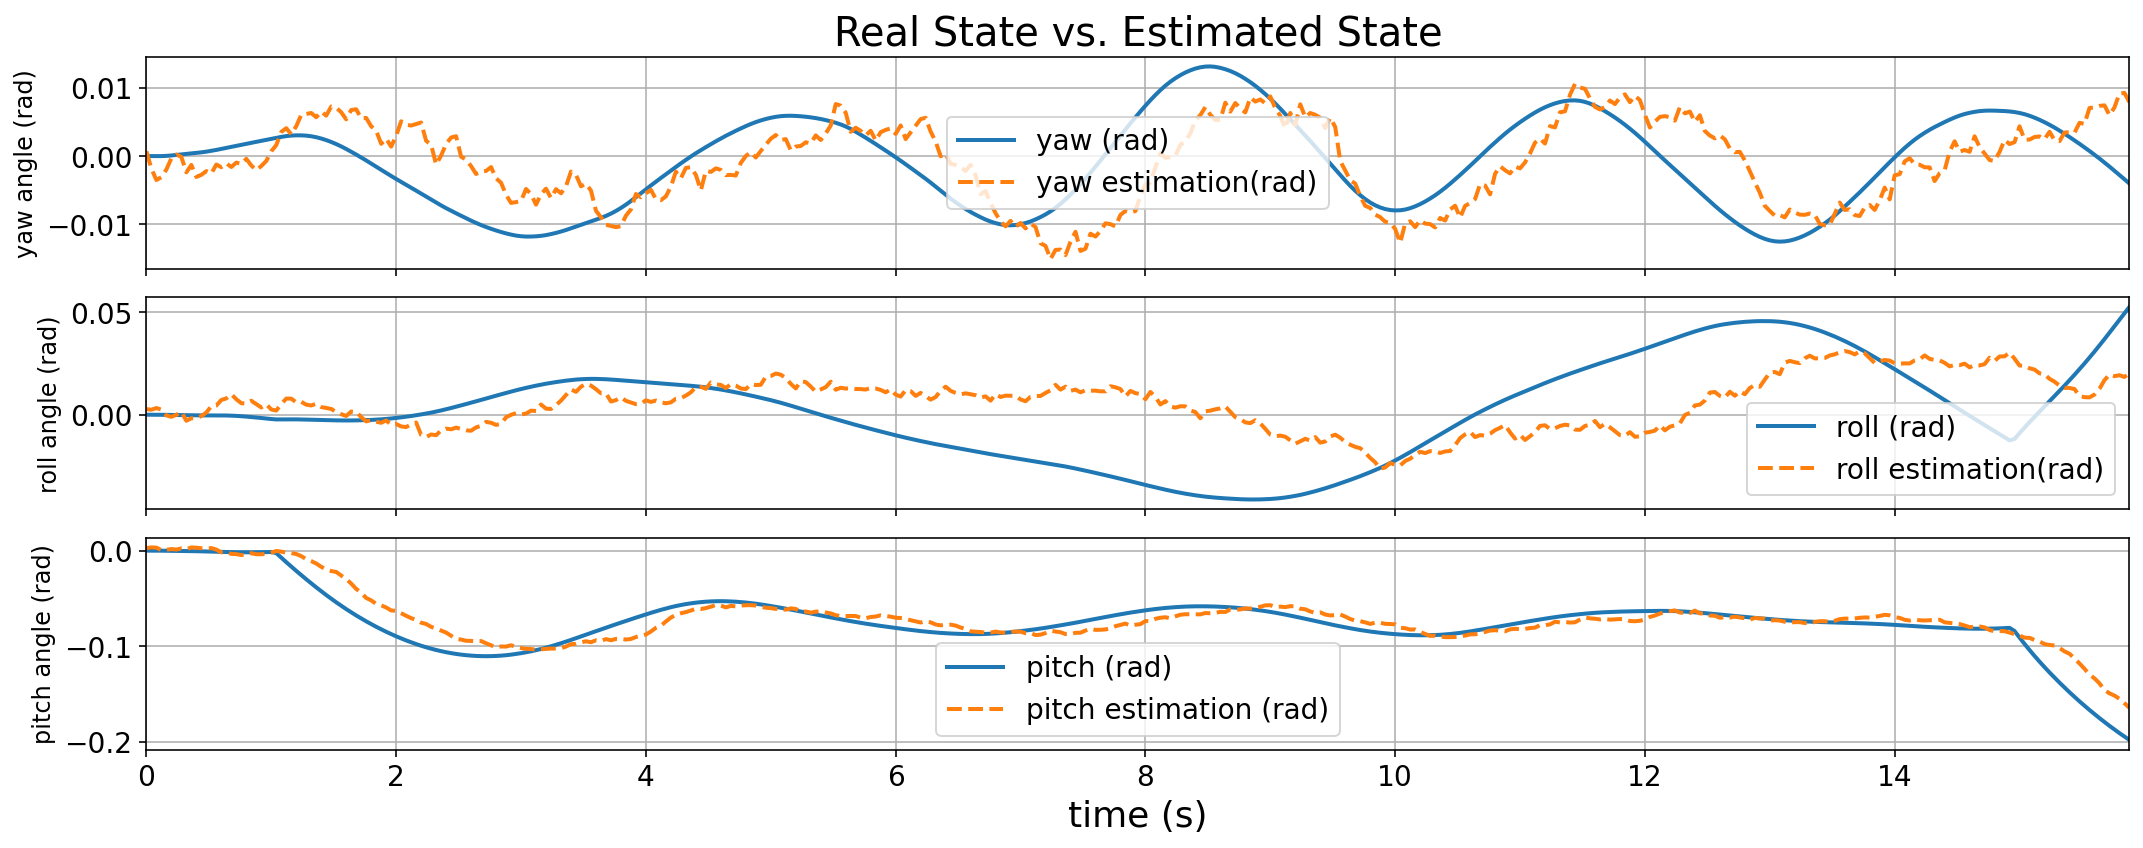

In [25]:
# get estimated state data
xhat = data['xhat']
time_dat = data["t"]
yawhat = xhat[:,0]
pitchhat = xhat[:,1]
rollhat = xhat[:,2]

# get real state data
yaw = data["yaw"]
roll = data["roll"]
pitch = data["pitch"]

# plot real state data
fig, (yaw_data, roll_data, pitch_data) = plt.subplots(3, 1, figsize=(15, 6), sharex=True)
yaw_data.plot(time_dat, yaw, label='yaw (rad)', linewidth=2)
roll_data.plot(time_dat, roll, label='roll (rad)', linewidth=2)
pitch_data.plot(time_dat, pitch, label='pitch (rad)', linewidth=2)

# plot state estimate data
yaw_data.plot(time_dat, yawhat, label='yaw estimation(rad)', linewidth=2, linestyle = "--")
roll_data.plot(time_dat, rollhat, label='roll estimation(rad)', linewidth=2, linestyle = "--")
pitch_data.plot(time_dat, pitchhat, label='pitch estimation (rad)', linewidth=2, linestyle = "--")

# set grids
yaw_data.grid()
roll_data.grid()
pitch_data.grid()

# add legends
yaw_data.legend(fontsize=14, loc='best')
yaw_data.tick_params(labelsize=14)
roll_data.legend(fontsize=14, loc='best')
roll_data.tick_params(labelsize=14)
pitch_data.legend(fontsize=14, loc='best')
pitch_data.tick_params(labelsize=14)

# limit chart x axis
yaw_data.set_xlim([time_dat[0], time_dat[-1]])
roll_data.set_xlim([time_dat[0], time_dat[-1]])
pitch_data.set_xlim([time_dat[0], time_dat[-1]])

# set axis labels
pitch_data.set_xlabel('time (s)', fontsize=18)
pitch_data.set_ylabel('pitch angle (rad)', fontsize=12)
roll_data.set_ylabel('roll angle (rad)', fontsize=12)
yaw_data.set_ylabel('yaw angle (rad)', fontsize=12)

yaw_data.set_title("Real State vs. Estimated State", fontsize = 20)
fig.tight_layout()